# Analysis of Stocks

Finance has a long and noble history of recording, logging, and analyzing data. We spend a little time here looking at the performance of Yahoo stocks over the years. This comes from a cute little tutorial put together by the good folks at [Towards Data Science](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7).

We start by importing some basic modules. Note the use of `pandas_datareader`. This is the tool we will use to import the stock prices.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import datetime
import pandas_datareader.data as web

We next import the Apple stock prices from YahooFinance dataset. We will restrict our attention to the time interval spanning January 1, 2010 to January 11, 2010.

In [4]:
# Define time interval
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

# Import data
df = web.DataReader('AAPL', 'yahoo', start, end)

# Take a peak at the data
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.419203
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.464878
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.043921
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,25.995777
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.168606


Our choice of metric for stock performance will be the [adjusted close price](https://www.investopedia.com/terms/a/adjusted_closing_price.asp). As we can see from above, this is the last column in the dataframe.

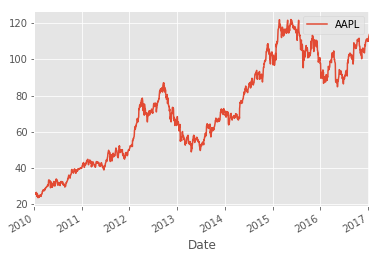

In [8]:
close_prc = df['Adj Close']

plt.figure()
close_prc.plot(label='AAPL')
plt.legend()

## Rolling (Moving) Average
Although there is an upward trend, there are significant short term variations that are uncorrelated with the long term, upward trend. A simple means of smoothing out these short term fluctuations is the [rolling average](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html). We demonstrate its use here.

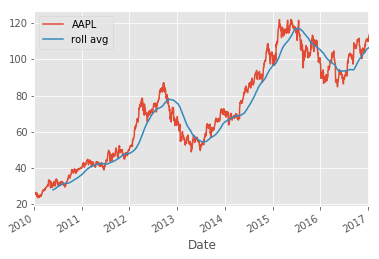

In [10]:
roll_avg = close_prc.rolling(window=100).mean()

plt.figure()
close_prc.plot(label='AAPL')
roll_avg.plot(label='roll avg')
plt.legend()

We see how the rolling average highlights the general trends. 

## Rate of Return
The rate of return (RoR) of an investment in an asset is a measure of the change in an assets value. If we denote the price of the asset at time $t$ as $p_t$, the then RoR over time interval $\Delta t$ is given by 
$$
  \mathrm{RoR} = \frac{p_{t+\Delta t} - p_t}{p_t}\times 100.
$$
Roughly speaking, it is the percentage by which your investment in that asset increased (or decreased). We can calculate the RoR for the Apple stock prices from above. As above, this value shows significant day-to-day fluctuations. Suppose we don't want to actively monitor our investment day-to-day, but rather on a montly basis. Then a rolling average with a month long window may be informative:

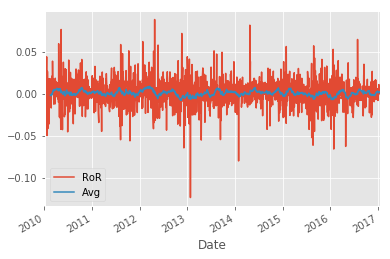

In [26]:
RoR = (close_prc - close_prc.shift(1))/close_prc.shift(1)
RoR_roll = RoR.rolling(window=30).mean()

plt.figure()
RoR.plot(label='RoR')
RoR_roll.plot(label='Avg')
plt.legend()

## Peer Comparison
Let us compare how Apple did in this time range with other giant techn companies. We will consider Apple, Google, GE, IBM, Microsoft, and Intel. We import the data similar to before and immediately grab the adjusted closing price.

In [28]:
df_comp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT', 'INTC'], 'yahoo', start, end)['Adj Close']
df_comp.head()

Symbols,AAPL,GE,GOOG,IBM,INTC,MSFT
Date,,,,,,
2010-01-04,26.419203,10.858186,312.204773,93.500313,15.063472,24.226894
2010-01-05,26.464878,10.914412,310.829926,92.370834,15.056260,24.234720
2010-01-06,26.043921,10.858186,302.994293,91.770790,15.005755,24.085989
2010-01-07,25.995777,11.420421,295.940735,91.453102,14.861475,23.835503
2010-01-08,26.168606,11.666402,299.885956,92.370834,15.027405,23.999893


### Correlation Analysis
Much of portfolio diversification hinges on markets being uncorrelated. Hence, a first question to ask ourselves is how correlated two markets are: if they are highly correlated, then splitting your investment into both does not count as diversification!

Let's investigate correlations between the tech giants here. We look at the percent change of each stock price compared to the previous day, and then build a correlation table:

In [31]:
pct_chng = df_comp.pct_change()
corr = pct_chng.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,INTC,MSFT
Symbols,,,,,,
AAPL,1.000000,0.381502,0.411693,0.383840,0.392943,0.393467
GE,0.381502,1.000000,0.422301,0.535174,0.517000,0.474069
GOOG,0.411693,0.422301,1.000000,0.403014,0.375164,0.472083
IBM,0.383840,0.535174,0.403014,1.000000,0.503645,0.496674
INTC,0.392943,0.517000,0.375164,0.503645,1.000000,0.560947
MSFT,0.393467,0.474069,0.472083,0.496674,0.560947,1.000000


Recall that a positive number implies the two values are positively correlated (when one goes up, the other goes up), a negative value impliest negative correlation (when one goes up, the other goes down). Numbers close to zero imply zero correlation (when one goes up, who knows what the other does!).

Staring at numbers is rarely useful, so let's make a visual that communicates this information more efficiently. We will focus on Microsoft and Apple for the moment.

Text(0, 0.5, 'Returns Microsoft')

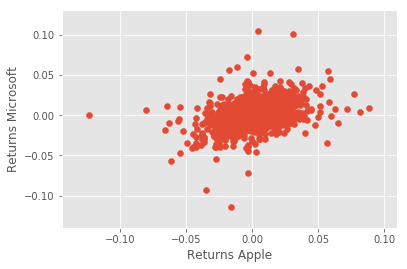

In [32]:
plt.scatter(pct_chng.AAPL, pct_chng.MSFT)
plt.xlabel('Returns Apple')
plt.ylabel(r'Returns Microsoft')

We see a slight positive correlation between the two archnemisis.

We can extend this analysis to compare all pairs of companies by plotting the scatter matrix. We will plot the Kernel Density Estimator along the diagonals (more on this in a second!).

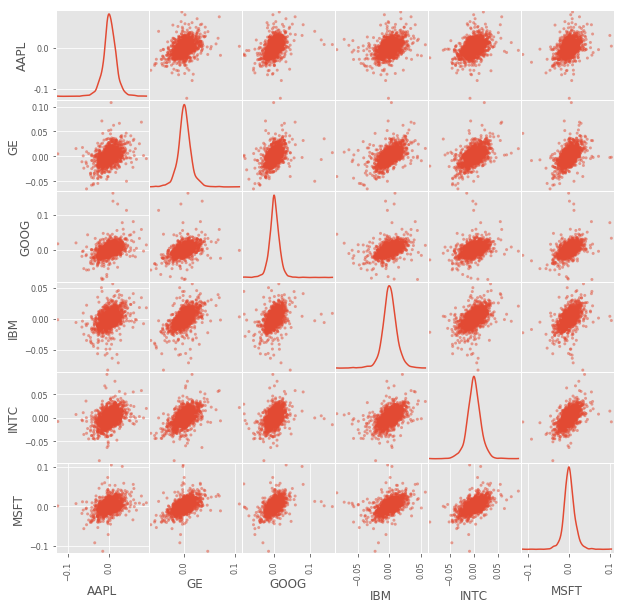

In [42]:
pd.plotting.scatter_matrix(pct_chng, diagonal='kde', figsize=(10,10))
plt.show()

Along the diagonals we see the Kernel Density Estimator. Conceptually, we can think of this as a smoothed out histogram. In this case, it is showing how many instances the percent change was a given value. Notice that IBM and Apple are skewed to the right of zero, implying they tended to have more positive percent changes than negative.

The off-diagonals are the scatter plots comparing the performance of every pair of companies. All in all we see positive correlations for all pairs. We can also plot the correlation matrix itself, using a heat map.

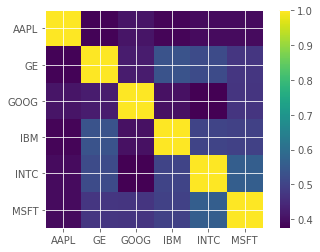

In [44]:
plt.imshow(corr, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

In this plot, the closer to yellow, the more positive the correlation. We see that there are definitive correlations within the market. Consequently, don't invest *all* of your resources into giant tech companies!

### Stocks Returns Rate and Risk
We already saw the rate of return of a stock, which measures what return you can expect back from your investment. Note that this is just the percent change of the investment. We take the mean of the RoR to get the expected returns from and investment in a given asset. To measure the risk, we look at how wildly the RoR fluctuated about that mean. That is, we measure the standard deviation of returns. 

To save space, we will plot these two values, expected returns and risk, agains eachother in a scatter plot.

In [49]:
pct_chng.mean()

Symbols
AAPL    0.000961
GE      0.000626
GOOG    0.000660
IBM     0.000310
INTC    0.000563
MSFT    0.000615
dtype: float64

(0.011, 0.017)

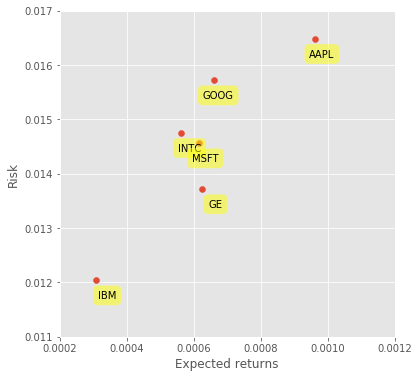

In [67]:
plt.figure(figsize=(6,6))
plt.scatter(pct_chng.mean(), pct_chng.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(pct_chng.columns, pct_chng.mean(), pct_chng.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
plt.xlim(0.0002,.0012)
plt.ylim(0.011, 0.017)

Note the clear positive correlation between Expected returns and risk. In a way this is unfortunate, but it also keeps the game balanced. If an asset demonstrated arbitrarily large returns and arbitrarily small risk, everyone would invest in it. This has direct implications for portfolio analysis, the seminal theory of which was developed by Harry Markowitz